## Toxic Comment Classification using LSTM model

In [1]:
import os
os.mkdir('templates')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import zipfile

In [3]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense,Embedding, Input , Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers

In [4]:
index = '''
<!DOCTYPE html>
<html>
<head>
<style>

/* This controls th style of the text area where user provide input */
textarea {
    width: 100%;
    height: 50px;
    padding: 12px 20px;
    box-sizing: border-box;
    border: 2px solid #ccc;
    background-color: #f8f8f8;
    font-size: 20px;
    
}

</style>

<body>
<p><strong>Toxic Comment Classifier:</strong></p>

<form action="/predictions", method = "POST">
  <textarea name="text">Type comment here then press "submit" </textarea>
  <input type="submit">
</form>
</body>
</html>
'''

preds = '''
<!DOCTYPE html>
<html>
<head>
	<title>Prediction</title>
</head>
<body>
<h1>{{text}}</h1>
<br>
<h2>Toxic: {{p[0]}}</h2>
<h2>Severe Toxic: {{p[1]}}</h2>
<h2>Obscene: {{p[2]}}</h2>
<h2>Threat: {{p[3]}}</h2>
<h2>Insult: {{p[4]}}</h2>
<h2>Identity Hate: {{p[5]}}</h2>
</body>
</html>

'''
f1 = open('templates/preds.html', 'w')
f2 = open('templates/index.html', 'w')
f1.write(preds)
f2.write(index)
f1.close()
f2.close()

In [5]:
from zipfile import ZipFile
zf = ZipFile('/content/jigsaw-toxic-comment-classification-challenge.zip', 'r')
zf.extractall('./content')
zf.close()

In [6]:
train = pd.read_csv('/content/content/train.csv.zip')
test = pd.read_csv('/content/content/train.csv.zip')

In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [9]:
train.shape

(159571, 8)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Comments count')

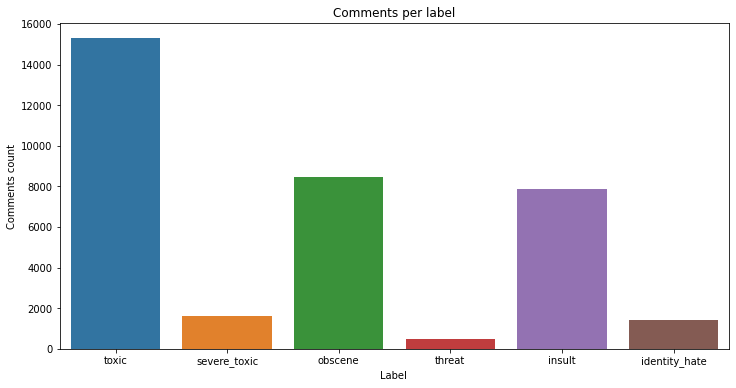

In [10]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
count = train[classes].sum()

plt.figure(figsize=(12,6))
df = sns.barplot(count.index, count.values)

plt.title("Comments per label")
plt.xlabel('Label ')
plt.ylabel('Comments count')

In [15]:
class ToxicClassifier(): 
  def preprocess(self, text):
    text = text.lower()
    text = " ".join(text.split())
    max_features = 20000
    maxlen = 200
    text = [text]
    tokenizer = Tokenizer(num_words=max_features, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True)
    tokenizer.fit_on_texts(list(text))
    tokenized = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(tokenized, maxlen=maxlen)
    return padded

  def get_model(self):
    maxlen = 200
    max_features = 20000
    embed_size = 128
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(LSTM(50, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(6, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [19]:
!pip install flask-ngrok
from flask import Flask, render_template
from flask import request
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app) 

In [20]:
@app.route('/')
def input():
  return render_template('index.html')

In [21]:
@app.route('/predictions', methods=["GET", "POST"])
def preds():
  if request.method == "POST":
    text = request.form.get('text')
    tcc = ToxicClassifier()
    processed = tcc.preprocess(text)
    model = tcc.get_model()
    pred = model.predict(processed)[0]
    return render_template('preds.html', p = pred, text = text)

In [22]:
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://3d5c47c7219f.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [21/Jan/2021 14:29:36] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jan/2021 14:29:37] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/Jan/2021 14:29:52] "POST /predictions HTTP/1.1" 200 -
